PUG Talk based on Daniel Nouri tutorial at http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/

In [1]:
from lasagne import layers, nonlinearities
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from sklearn.preprocessing import StandardScaler
from scipy.misc import imread, imsave, imresize
%matplotlib nbagg

<IPython.core.display.Javascript object>


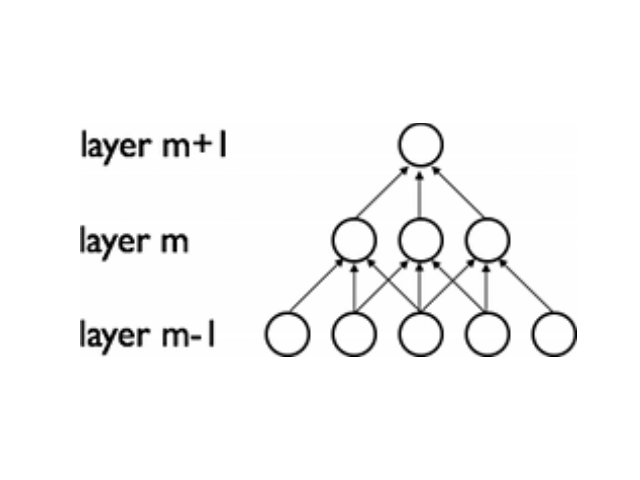

In [2]:
from utils import showimg
showimg("sparse_1D_nn.png")
plt.show()

In [38]:

np.random.choice(img_fnames.values.ravel()[0:1])

'lfw/Derek_Bond/Derek_Bond_0001.jpg'

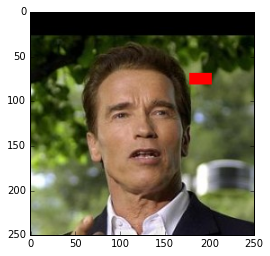

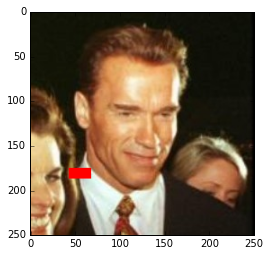

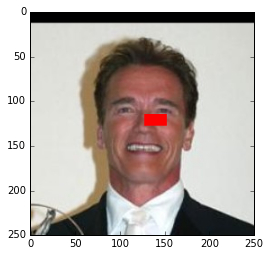

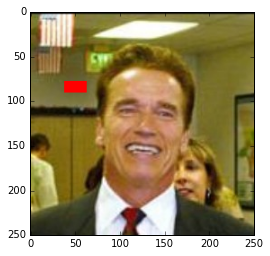

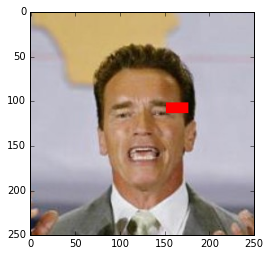

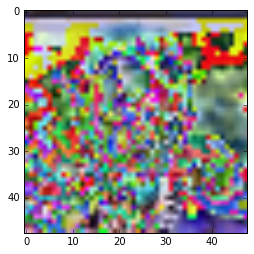

In [50]:
from utils import add_circle, add_rect
import pandas as pd

def load(data_len, standarize = True, shrink = True):
    np.random.seed(46)
    img_fnames = pd.read_csv("./lfw_files.txt").values.ravel()[0:40]
    Xb = []
    yb = []
    
    for i in range(data_len):
        image = imread(np.random.choice(img_fnames))
        if shrink:
            size_x = 48
            size_y = 48
        else:
            size_x = image.shape[0]
            size_y = image.shape[1]
        if np.random.random() > 0.5:
            Xb.append(imresize(add_rect(image), (size_x,size_y,3)).swapaxes(0,2).swapaxes(1,2))
            yb.append(0)
        else:
            Xb.append(imresize(add_circle(image), (size_x,size_y,3)).swapaxes(0,2).swapaxes(1,2))
            yb.append(1)
    Xb = np.array(Xb)
    if standarize:
        n,c,x,y = Xb.shape
        Xb = Xb.reshape((n,x*y*c))
        sc = StandardScaler(with_mean=True, with_std=True)
        Xb = sc.fit_transform(Xb)
        #Xb = Xb.T
        Xb = Xb.reshape((n,c,x,y))
    return Xb, np.array(yb, dtype=np.int32)

%matplotlib inline
X, y = load(5, standarize=False,shrink=False)
for i in range(5):
    fig = plt.figure()
    plt.imshow(X[i].swapaxes(0,2).swapaxes(0,1))
X, y = load(5)
fig = plt.figure()
plt.imshow(X[0].swapaxes(0,2).swapaxes(0,1))

In [10]:
net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, size_x,size_y,3),  # 96x96 input pixels per batch
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=nonlinearities.softmax,
    output_num_units=2,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=False,  # flag to indicate we're dealing with regression problem
    max_epochs=20,  # we want to train this many epochs
    verbose=1,
    )
np.random.seed(40)
X, y = load(500)
net1.fit(X, y)

NameError: name 'size_x' is not defined

In [53]:
net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 3, 96, 96),
    conv1_num_filters=8, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=16, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=32, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=200, hidden5_num_units=200,
    output_num_units=2,
    output_nonlinearity=nonlinearities.softmax,

    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=False,
    max_epochs=40,
    verbose=1,
    )
np.random.seed(40)
X, yb = load(1000)
n,c,x,y = X.shape
X = X.reshape((n,x*y*c))
sc = StandardScaler(with_mean=True, with_std=True)
X = sc.fit_transform(X.T)
X = X.T
X = X.reshape((n,c,x,y))
net1.fit(X, yb)

# Neural Network with 818034 learnable parameters

## Layer information

  #  name     size
---  -------  --------
  0  input    3x96x96
  1  conv1    8x94x94
  2  pool1    8x47x47
  3  conv2    16x46x46
  4  pool2    16x23x23
  5  conv3    32x22x22
  6  pool3    32x11x11
  7  hidden4  200
  8  hidden5  200
  9  output   2

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       0.70187       0.69700      1.00698      0.49759  14.91s
      2       0.68768       0.69387      0.99108      0.52301  15.16s
      3       0.67373       0.69193      0.97369      0.53179  16.54s
      4       0.65953       0.68890      0.95737      0.53569  16.92s
      5       0.64343       0.68916      0.93364      0.52103  15.77s
      6       0.62759       0.69881      0.89809      0.54056  15.65s
      7       0.62084       0.69653      0.89133      0.53569  17.80s
      8       0.59776       0.70311      0.8501

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7efffc070a50>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7efffc0709d0>,
     conv1_filter_size=(3, 3), conv1_num_filters=8,
     conv2_filter_size=(2, 2), conv2_num_filters=16,
     conv3_filter_size=(2, 2), conv3_num_filters=32, custom_score=None,
     hidden4_num_units=200, hidden5_num_units=200,
     input_shape=(None, 3, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv3', <class..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=40, more_params={},
     objective=<function objective at 0x7efffc075b18>,
     objective_lo

In [ ]:
net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        #('conv3', layers.Conv2DLayer),
        #('pool3', layers.MaxPool2DLayer),
        ('drop1', layers.DropoutLayer), # Added dropout
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 3, size_x, size_y),
    conv1_num_filters=8, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=16, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    #conv3_num_filters=32, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    drop1_p = 0.5,
    hidden4_num_units=200, hidden5_num_units=200,
    output_num_units=2,
    output_nonlinearity=nonlinearities.softmax,

    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=False,
    max_epochs=40,
    verbose=1,
    )
np.random.seed(40)
Xb, yb = load(8000)

net1.fit(Xb, yb)

# Neural Network with 428754 learnable parameters

## Layer information

  #  name     size
---  -------  --------
  0  input    3x48x48
  1  conv1    8x46x46
  2  pool1    8x23x23
  3  conv2    16x22x22
  4  pool2    16x11x11
  5  drop1    16x11x11
  6  hidden4  200
  7  hidden5  200
  8  output   2

